In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

# Option 1: Simple CNN from scratch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after convolutions and pooling
        # Input: 224x224 -> After 3 pool layers: 28x28
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # x starts as (batch_size, 3, 224, 224)
        x = self.pool(self.relu(self.conv1(x)))  # -> (batch_size, 16, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # -> (batch_size, 32, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # -> (batch_size, 64, 28, 28)
        x = x.view(-1, 64 * 28 * 28)  # Flatten the output
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Option 2: Transfer Learning with ResNet
class ResNetTransfer(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetTransfer, self).__init__()
        # Load pretrained ResNet18
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # Freeze all layers
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Example usage:
def main():
    # Create instances of both models
    simple_cnn = SimpleCNN(num_classes=3)
    resnet_transfer = ResNetTransfer(num_classes=3)
    
    # Print model summaries
    print("Simple CNN Architecture:")
    print(simple_cnn)
    print("\nResNet Transfer Learning Architecture:")
    print(resnet_transfer)

main()

Simple CNN Architecture:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

ResNet Transfer Learning Architecture:
ResNetTransfer(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kern

In [20]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset path
path_to_dataset = "document_classification"

# Load dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(root=path_to_dataset, transform=transform)

# Split the dataset into training and testing sets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Configurable parameters
batch_size = 4
num_workers = 2

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Training and testing data loaders are ready.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Check the data loader
for images, labels in train_loader:
    print("Image batch dimensions:", images.size())
    print("Label batch dimensions:", labels.size())
    break


Training and testing data loaders are ready.
Number of training samples: 132
Number of testing samples: 33
Image batch dimensions: torch.Size([4, 3, 224, 224])
Label batch dimensions: torch.Size([4])


In [3]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
        
        # Evaluate the model
        test_model(model, test_loader)

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

## Train and test the SimpleCNN model


In [8]:
# Choose model
simp_model = SimpleCNN(num_classes=3)

# Train and evaluate
train_model(simp_model, train_loader, test_loader, num_epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 1.4280
Accuracy on test set: 75.76%
Epoch 2/10, Loss: 0.7512
Accuracy on test set: 66.67%
Epoch 3/10, Loss: 0.7615
Accuracy on test set: 72.73%
Epoch 4/10, Loss: 0.4694
Accuracy on test set: 87.88%
Epoch 5/10, Loss: 0.6061
Accuracy on test set: 69.70%
Epoch 6/10, Loss: 0.3488
Accuracy on test set: 69.70%
Epoch 7/10, Loss: 0.3424
Accuracy on test set: 69.70%
Epoch 8/10, Loss: 0.3197
Accuracy on test set: 81.82%
Epoch 9/10, Loss: 0.1653
Accuracy on test set: 81.82%
Epoch 10/10, Loss: 0.2349
Accuracy on test set: 57.58%


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_predictions(model, test_loader, device, class_names, num_images=8):
    """Visualize model predictions on a batch of test images."""
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Plot images in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # Denormalize the image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.5, 0.5, 0.5])
                std = np.array([0.5, 0.5, 0.5])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return
    
    plt.tight_layout()
    plt.show()

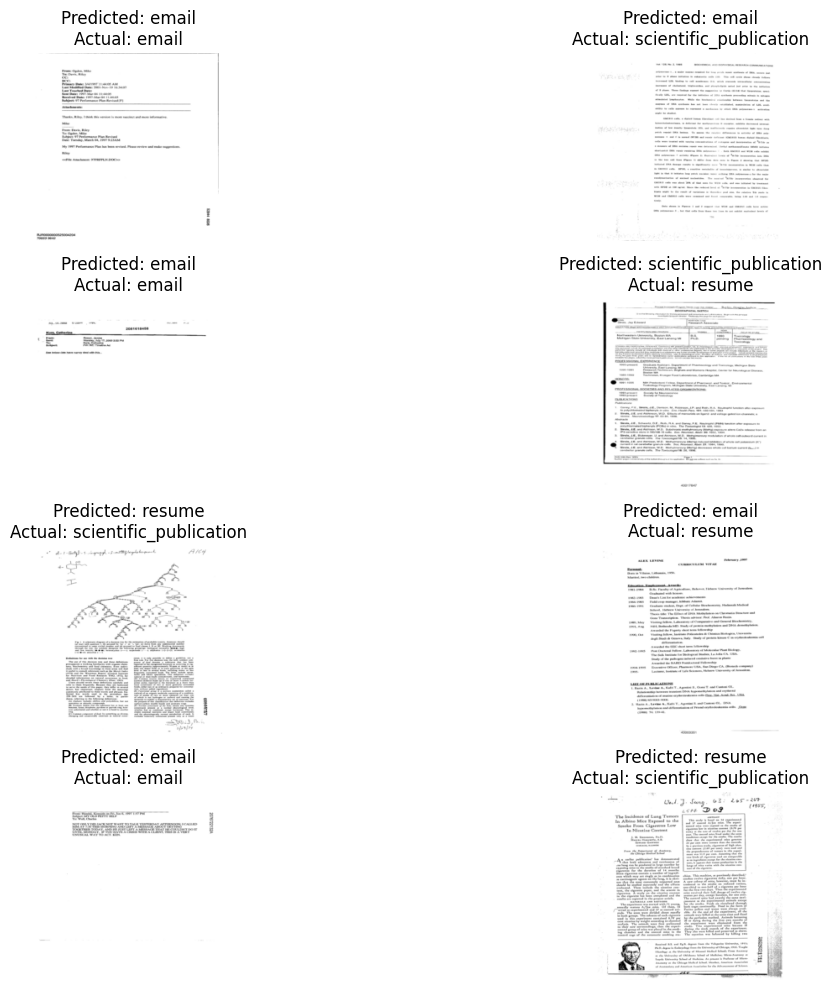

In [10]:
# Define class names
class_names = ['email', 'resume', 'scientific_publication']

# Visualize model predictions
visualize_model_predictions(simp_model, test_loader, device, class_names, num_images=8)

## Train and test the ResNet Model using transfer learning


In [11]:
resnet_model = ResNetTransfer(num_classes=3)
train_model(resnet_model, train_loader, test_loader, num_epochs=10, learning_rate=0.001)

Epoch 1/10, Loss: 1.0250
Accuracy on test set: 69.70%
Epoch 2/10, Loss: 0.7896
Accuracy on test set: 75.76%
Epoch 3/10, Loss: 0.8172
Accuracy on test set: 81.82%
Epoch 4/10, Loss: 0.6975
Accuracy on test set: 75.76%
Epoch 5/10, Loss: 0.6204
Accuracy on test set: 84.85%
Epoch 6/10, Loss: 0.4861
Accuracy on test set: 75.76%
Epoch 7/10, Loss: 0.4508
Accuracy on test set: 84.85%
Epoch 8/10, Loss: 0.5698
Accuracy on test set: 87.88%
Epoch 9/10, Loss: 0.4984
Accuracy on test set: 90.91%
Epoch 10/10, Loss: 0.5561
Accuracy on test set: 90.91%


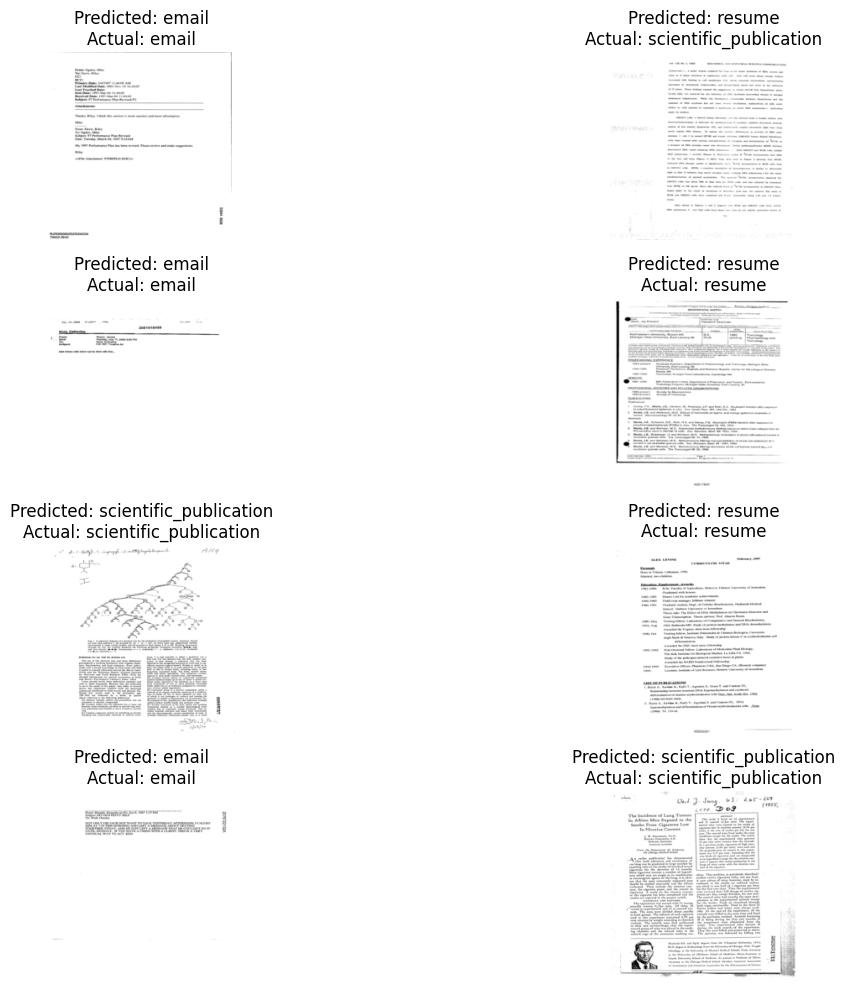

In [12]:
visualize_model_predictions(resnet_model, test_loader, device, class_names, num_images=8)

### Conclusion

After training a simple CNN network I have got an accuracy of max 87.88%. The problem is that everytime the results are unstable and is prone to overfitting.

On the other hand, using transfer learning on ResNet, gave better results (90.91%) and did not overfit the dataset.
